In [ ]:
#%pip install qiskit qiskit-ibm-runtime
#%pip install 'qiskit[visualization]'
#%pip install qiskit_aer
#%pip install matplotlib
#%pip install pylatexenc
#%pip install prototype-zne

"%pip install qiskit qiskit-ibm-runtime\n%pip install 'qiskit[visualization]'\n%pip install qiskit_aer\n%pip install matplotlib\n%pip install pylatexenc\n%pip install prototype-zne"

circuit to form a phi-plus Bell state

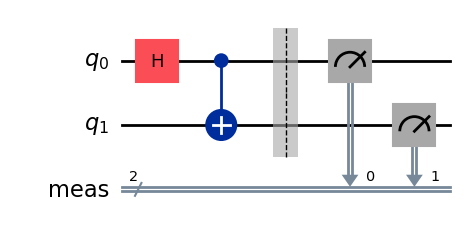

In [2]:
from qiskit import QuantumCircuit

# Apply gates to the provided QuantumCircuit, qc

qc = QuantumCircuit(2)

qc.h(0) #Hadamard
qc.cx(0,1) #CNOT

qc.measure_all()
qc.draw('mpl')

In [3]:
from qiskit.primitives import StatevectorSampler

sampler = StatevectorSampler()
pub = qc
job_sampler = sampler.run([pub])


result_sampler = job_sampler.result()
counts_sampler = result_sampler[0].data.meas.get_counts()

print(counts_sampler)

{'11': 510, '00': 514}


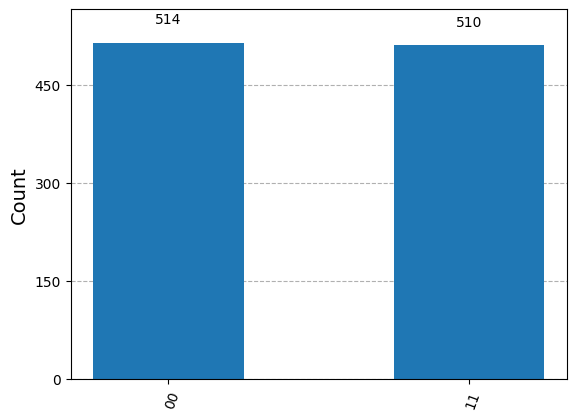

In [4]:
from qiskit.visualization import plot_histogram

plot_histogram(counts_sampler)

circuit to form a psi-minus Bell state

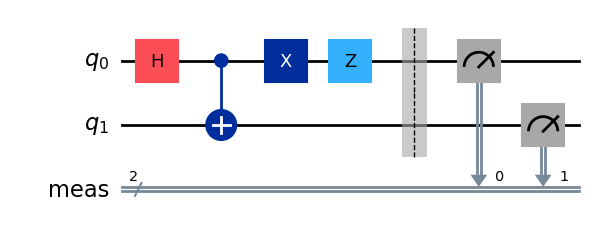

In [5]:
# circuit to form a psi-minus Bell state

# Apply gates to the provided QuantumCircuit, qc

qc = QuantumCircuit(2)

qc.h(0)
qc.cx(0,1)
qc.x(0)
qc.z(0)

qc.measure_all()
qc.draw('mpl')

In [6]:
sampler = StatevectorSampler()
pub = qc
job_sampler = sampler.run([pub])


result_sampler = job_sampler.result()
counts_sampler = result_sampler[0].data.meas.get_counts()

print(counts_sampler)

{'10': 494, '01': 530}


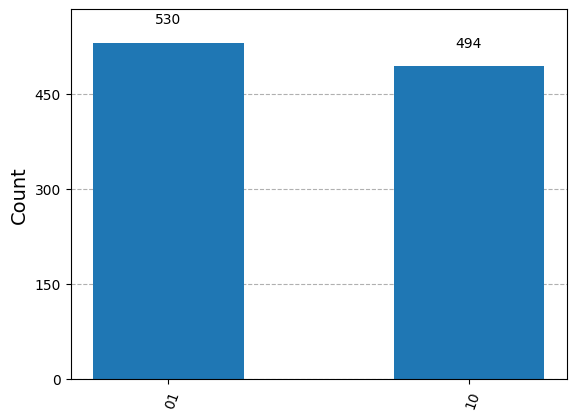

In [7]:
plot_histogram(counts_sampler)

Grover's Algorithm

In [8]:

import math

# Imports from Qiskit
from qiskit import QuantumCircuit
from qiskit.circuit.library import GroverOperator, MCMT, ZGate
from qiskit.visualization import plot_distribution

# Imports from Qiskit Runtime
from qiskit_ibm_runtime import QiskitRuntimeService
from qiskit_ibm_runtime import SamplerV2 as Sampler

In [9]:

#Load the Qiskit Runtime service
from qiskit_ibm_runtime import QiskitRuntimeService


# Syntax for first saving your token
QiskitRuntimeService.save_account(channel="ibm_quantum", token="51d843421456b6ef179496703907f6319cf555dc54444bfa3e35bf4ba5e3a36280a6a1cc36fe307bdefc7192b0d1e778ebb7180277c50a6976573382efb8644a", overwrite=True, set_as_default=True)
service = QiskitRuntimeService(channel='ibm_quantum')

#Syntax for specifying a channel and instance (if your organization has one for you.
service = QiskitRuntimeService(channel="ibm_quantum", instance="ibm-q/open/main")


#Load the Runtime primitive and session
from qiskit_ibm_runtime import Options, Session, SamplerV2 as Sampler

#Use the least busy backend
#backend = service.least_busy(operational=True, simulator=False, min_num_qubits = 127)
backend = service.least_busy()
print(backend.name)

ibm_kyiv


In [10]:
def grover_oracle(marked_states):
    """Build a Grover oracle for multiple marked states

    Here we assume all input marked states have the same number of bits

    Parameters:
        marked_states (str or list): Marked states of oracle

    Returns:
        QuantumCircuit: Quantum circuit representing Grover oracle
    """
    if not isinstance(marked_states, list):
        marked_states = [marked_states]
    # Compute the number of qubits in circuit
    num_qubits = len(marked_states[0])

    qc = QuantumCircuit(num_qubits)
    # Mark each target state in the input list
    for target in marked_states:
        # Flip target bit-string to match Qiskit bit-ordering
        rev_target = target[::-1]
        # Find the indices of all the '0' elements in bit-string
        zero_inds = [ind for ind in range(num_qubits) if rev_target.startswith("0", ind)]
        # Add a multi-controlled Z-gate with pre- and post-applied X-gates (open-controls)
        # where the target bit-string has a '0' entry
        qc.x(zero_inds)
        qc.compose(MCMT(ZGate(), num_qubits - 1, 1), inplace=True)
        qc.x(zero_inds)
    return qc

Oracle

C:\Users\ASURA\AppData\Local\Temp\ipykernel_11304\2149212773.py:27: DeprecationWarning: The class ``qiskit.circuit.library.generalized_gates.mcmt.MCMT`` is deprecated as of qiskit 1.4. It will be removed no earlier than 3 months after the release date. Use MCMTGate instead.
  qc.compose(MCMT(ZGate(), num_qubits - 1, 1), inplace=True)


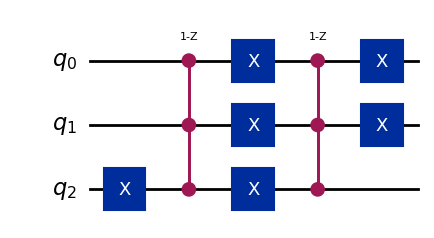

In [11]:
marked_states = ["011", "100"]

oracle = grover_oracle(marked_states)
oracle.draw(output="mpl", style="iqp")

Grover Diffusion

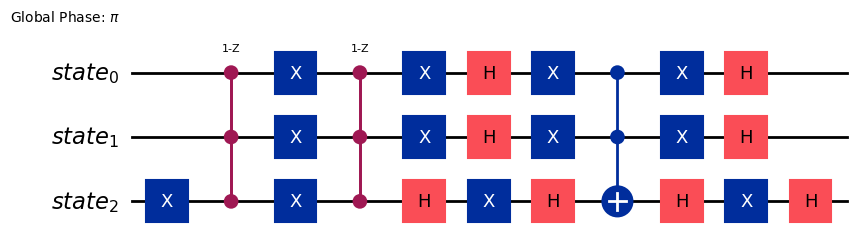

In [12]:
grover_op = GroverOperator(oracle)
grover_op.decompose().draw(output="mpl", style="iqp")

Number iterations

In [13]:
optimal_num_iterations = math.floor(
    math.pi / (4 * math.asin(math.sqrt(len(marked_states) / 2**grover_op.num_qubits)))
)

Final Circuit

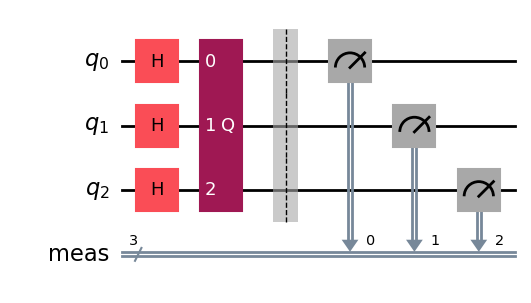

In [14]:
qc = QuantumCircuit(grover_op.num_qubits)
# Create even superposition of all basis states
qc.h(range(grover_op.num_qubits))
# Apply Grover operator the optimal number of times
qc.compose(grover_op.power(optimal_num_iterations), inplace=True)
# Measure all qubits
qc.measure_all()
qc.draw(output="mpl", style="iqp")

Quantum Simulator

In [15]:
# This uses a local simulator
from qiskit_aer import AerSimulator

# This generates a simulator that mimics the real quantum system
backend_sim = AerSimulator.from_backend(backend)

# Import an estimator, this time from qiskit (we import from Runtime for real hardware)
from qiskit.primitives import BackendSampler
sampler = BackendSampler(backend = backend_sim)

C:\Users\ASURA\AppData\Local\Temp\ipykernel_11304\2034267889.py:9: DeprecationWarning: The class ``qiskit.primitives.backend_sampler.BackendSampler`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseSamplerV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `BackendSampler` class is `BackendSamplerV2`.
  sampler = BackendSampler(backend = backend_sim)


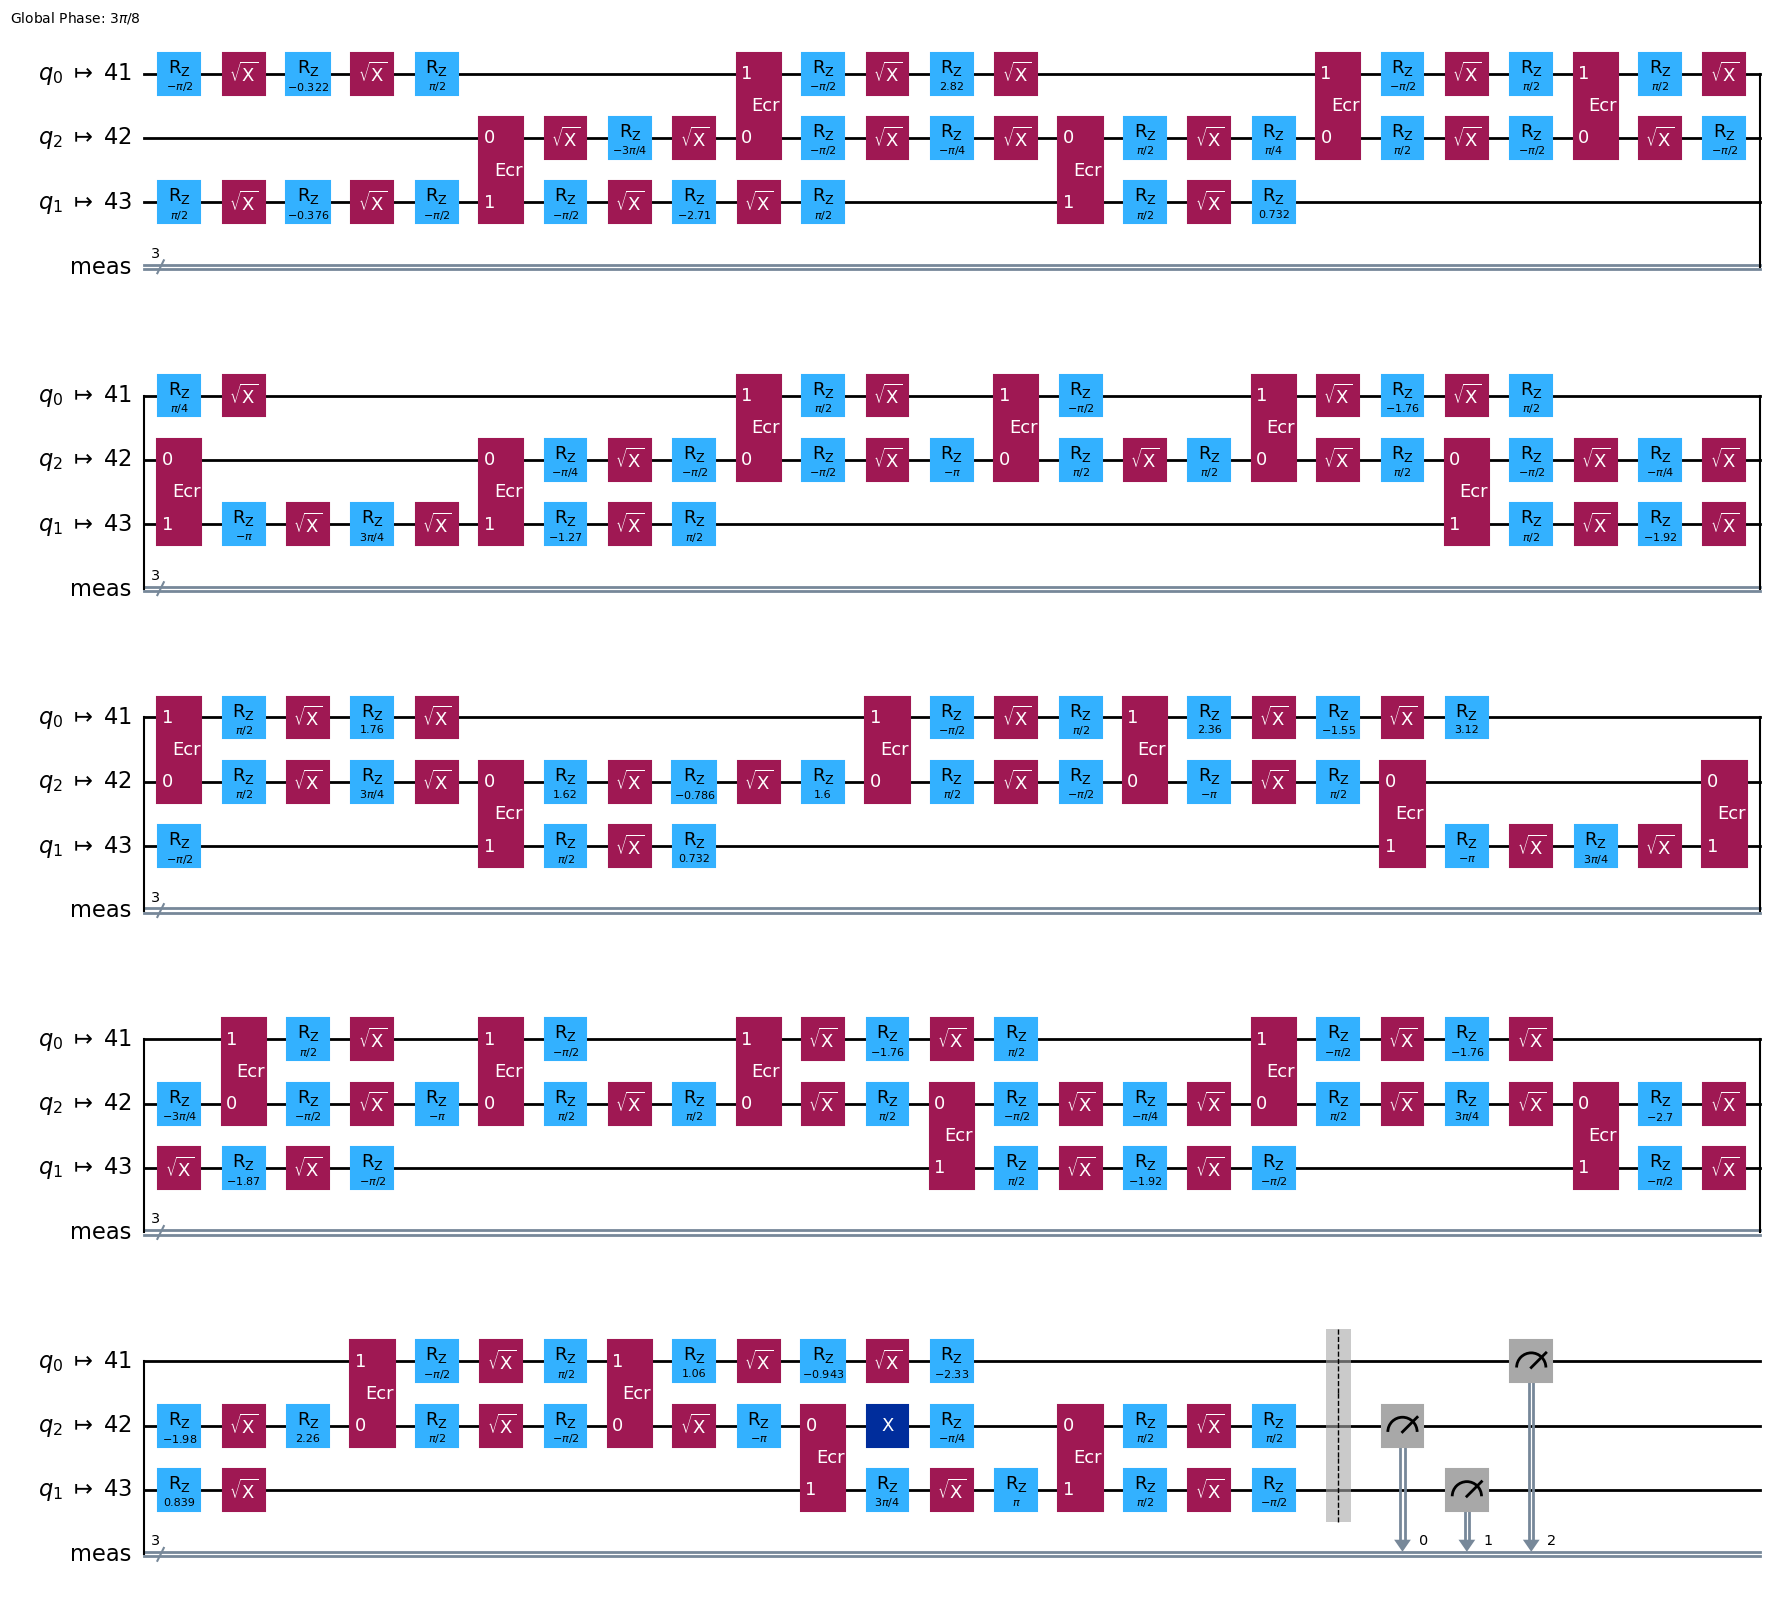

In [16]:
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager

target = backend_sim.target
pm = generate_preset_pass_manager(target=target, optimization_level=3)

circuit_isa = pm.run(qc)
circuit_isa.draw(output="mpl", idle_wires=False, style="iqp")

In [17]:
# To run on local simulator:
#   1. Use the SatetvectorSampler from qiskit.primitives instead
sampler = Sampler(mode=backend_sim)
sampler.options.default_shots = 10_000
result = sampler.run([circuit_isa]).result()
dist = result[0].data.meas.get_counts()

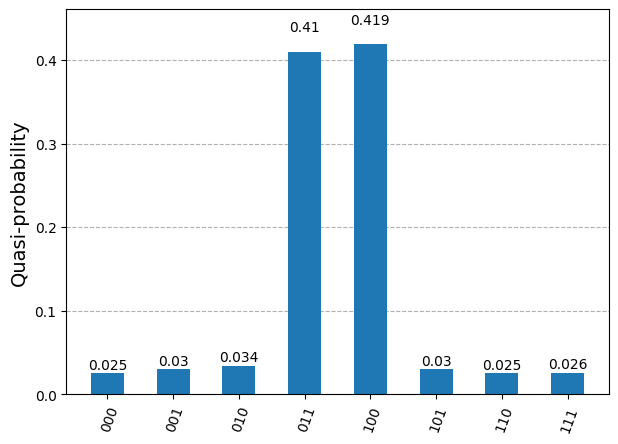

In [18]:
plot_distribution(dist)